In [3]:
%reload_ext autoreload
%autoreload 2
import functions
from functions import *
import os
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 20)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from lightgbm import LGBMClassifier
import joblib
import pickle
from mlflow.models.signature import infer_signature
import mlflow
import shap
from sklearn.feature_selection import RFE

ModuleNotFoundError: No module named 'functions'

In [2]:
%cd /Users/aleth/Documents/Python/0penclassroom/P7

/Users/aleth/Documents/Python/0penclassroom/P7


# Data

In [3]:
X_train = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('X_test.csv').drop('Unnamed: 0', axis=1)

In [4]:
y_train = pd.read_csv('y_train.csv').drop('Unnamed: 0', axis=1).squeeze()

In [5]:
X_train = np.array(X_train)

y_train = np.array(y_train)


# Model

In [9]:
# Best model (after Bayesian optimsation and search for best threshold 

lgbm_opt2 = LGBMClassifier(
            n_estimators=150,
            learning_rate=0.07149 ,
            num_leaves=29,
            colsample_bytree=0.8544 ,
            subsample=0.7983,
            max_depth=9,
            reg_alpha=0.008469,
            reg_lambda=0.008061,
            min_split_gain=0.07638 ,
            min_child_weight=37.43,
            silent=-1,
            verbose=-1, 
            class_weight='balanced')

Best_threshold = 0.5157894736842106

In [10]:
def lightGBM(X_train, y_train): 
    Best_threshold = 0.5157894736842106
    
    scl = MinMaxScaler()
    clf = lgbm_opt2
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    # entrainement et enregistrement du model
    pipe.fit(X_train, y_train)
    
    train_predict = pd.DataFrame(pipe.predict_proba(X_train)[: , 1])
    
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_train, train_predict)
    curve_train = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    # Class prediction with best threshold
    train_predict_class = train_predict.applymap(lambda x: 1 if x>Best_threshold else 0)
    cm_train = confusion_matrix(y_train, train_predict_class)
    cost_train = (10*cm_train[1][0] + cm_train[0][1])/len(y_train)*100
   
    # roc_curve with best threshold position
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    curve_train.plot(ax=ax)  
    ax.scatter(1-cm_train[0][0]/(cm_train[0][1]+cm_train[0][0]), cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]), marker='o', color='black', label='Best', linewidths=2)    
    ax.set_title('Train', weight='bold')
      
    # Confusion matrix
    confusion_train = ConfusionMatrixDisplay(cm_train)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    confusion_train.plot(ax=ax)
    
    
    print(f"\roc_auc train: \t{round(roc_auc_score(y_train, train_predict), 4)}")
    print(f"Cost train : \t{round(cost_train, 2)}")
    print(f"Accuracy : \t{round(accuracy_score(y_train, train_predict_class), 4)}")
    
    return pipe
    

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


oc_auc train: 	0.8221
Cost train : 	44.16
Accuracy : 	0.7515


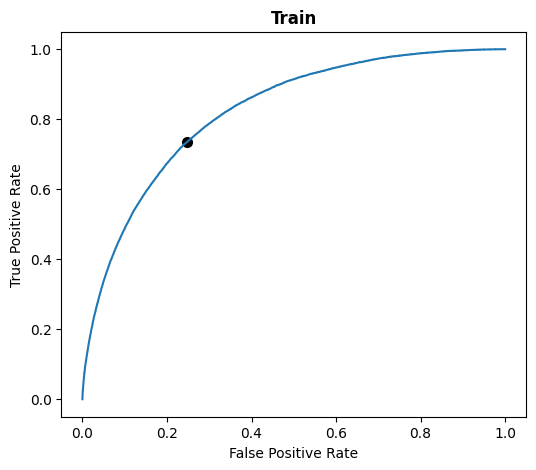

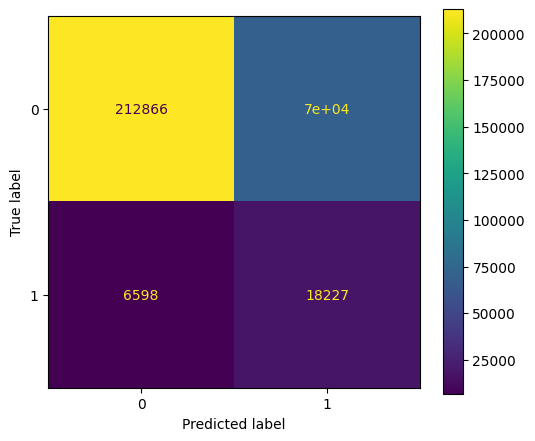

In [11]:
pipe_trained = lightGBM(X_train, y_train)

In [12]:
filename = 'lightGBM_definitif.pkl'
pickle.dump(pipe_trained, open(filename, 'wb'))

In [7]:

lightGBM_definitif = pickle.load(open('lightGBM_definitif.pkl', 'rb'))

In [8]:
def lightgbm_proba(data, model):
    return model.predict_proba(data)[0]

In [15]:
lightgbm_proba([X_train[0]], lightGBM_definitif)

array([0.20912374, 0.79087626])

In [13]:
lightGBM_definitif

# Feature importance
## Globale

In [9]:
features = pd.read_csv('features.csv')['features']

In [10]:
def features_importance(features_kept, model_trained, num_features):
    importance_df = pd.DataFrame()
    importance_df['feature'] = features_kept
    importance_df["importance"] = model_trained['clf'].feature_importances_
    importance_df["importance"] = importance_df["importance"].apply(lambda x: abs(x))
    plt.figure(figsize=(8, num_features*1/3))
    sns.barplot(x="importance", y="feature", data=importance_df.sort_values('importance', ascending=False).iloc[:num_features, :], color='blue', saturation=0.2)
    plt.title('Features Importance')
    return importance_df.sort_values('importance', ascending=False).iloc[:num_features, :]

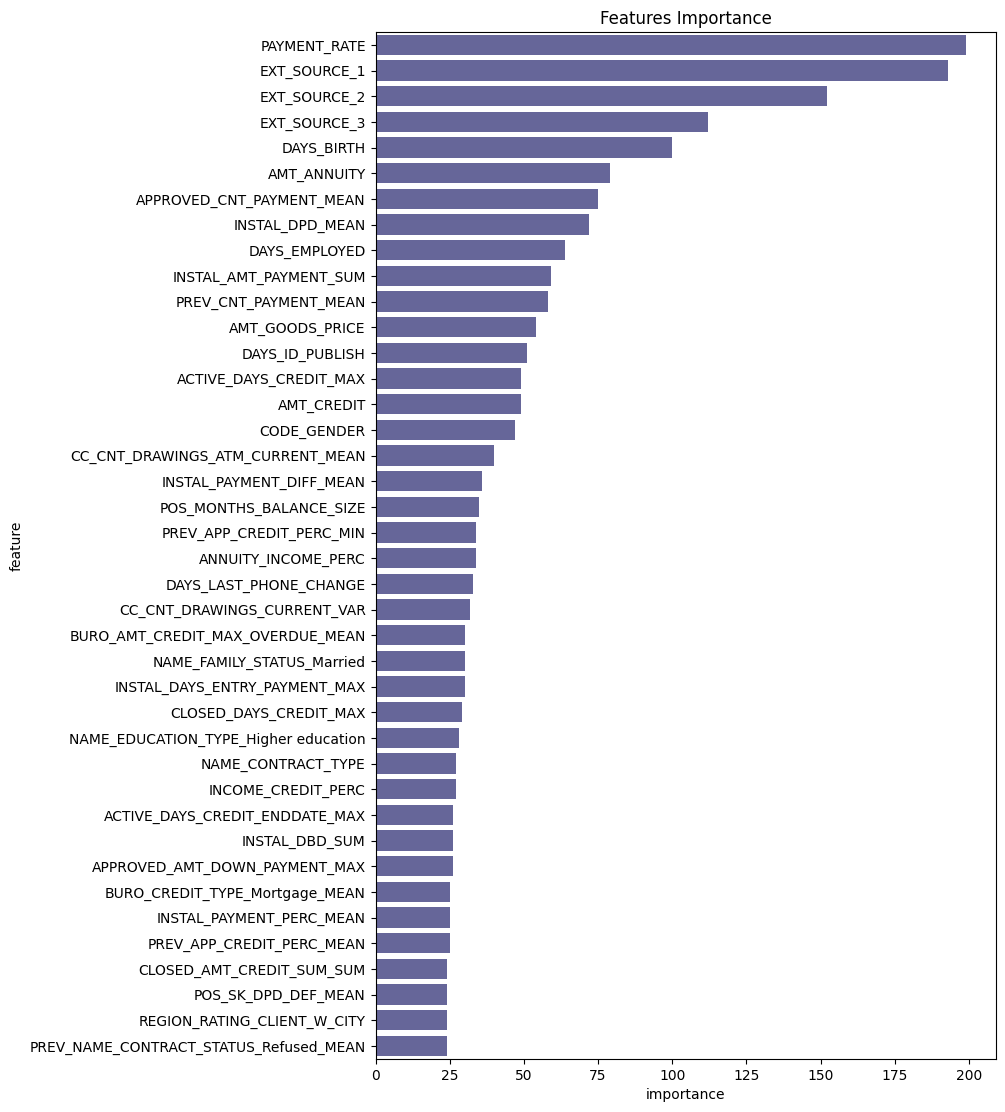

In [11]:
important_features = features_importance(features, lightGBM_definitif, 40)

In [12]:
features_20 = important_features.iloc[:20]['feature']

In [1]:
definitions = ['Ratio of loan annuity by credit amount of the loan', 
               'Normalized score from external data source 1', 
               'Normalized score from external data source 2', 
               'Normalized score from external data source 3',
               "Client's age in days at the time of application",
               'loan annuity',
               'Term of previous credit at application of the previous approved application',
               'Difference between when was the installements of previous credit paid actually and when it was actually paid', 
               'How many days before the application the client started current employment', 
               'what the client actulally paid on previous credit on this installment',
               'Term of previous credit at application of the previous application',
               'Price of the goods for which the loan is given',
               'How many days before the application did the client change the identity document with which he applied for the loan',
               'How many days before current application did the client apply for a credit bureau credit still active',
               'Credit amount of the loan',
               'Gender of the client',
               'Average number of drawings at ATM during a month on the previous application', 
               'Difference between what was the prescribed installment amount of the previous credit on this installment and the amount the client actually paid',
               'Month of balance relative to application date',
               'Ratio of how much credit did client ask on the previous application by the amount of the loan']

In [1]:
features_20['definitions'] = definitions

In [1]:
features_20.to_csv('features_20.csv')

## Local

In [22]:
# Background from Datatrain
sample = shap.utils.sample(pd.DataFrame(X_train), nsamples=100000)

In [20]:
#sample.to_csv('sample.csv')

In [21]:
expected_value =  y_train[sample.index]

In [21]:
#pd.DataFrame(expected_value).to_csv('expected_value.csv')

In [25]:
# Create explainer
features = pd.read_csv('features.csv')['features'].values
explainer = shap.TreeExplainer(lightGBM_definitif['clf'], sample)
filename_exp = 'explainer.pkl'
pickle.dump(explainer, open(filename_exp, 'wb'))

In [37]:
class WaterfallData():
    def __init__ (self, shap_test, col, expected_value, data):
        self.values = shap_test[col].values
        self.base_values = expected_value
        self.data = data
        self.feature_names = shap_test.index
        self.display_data = shap_test.index

In [48]:
def plot_features_importance(customer_input, shap_values, nb_features):
    features = pd.read_csv("features.csv")['features'].values
    expected_value_mean = pd.read_csv("expected_value.csv")['0'].mean()
    features_importantes = pd.DataFrame(index=features, columns=['shap'], data=shap_values[0])
    features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
    features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:nb_features]
    
    shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value_mean, customer_input), max_display=nb_features)
    st.pyplot(bbox_inches='tight',dpi=500, pad_inches=0)
    plt.clf()

# Model sans customer Id

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
def features_selection(X_train, y_train, model, nb_features):
    
    scl = MinMaxScaler()
    clf = RFE(estimator=model, n_features_to_select=nb_features, step=2, )
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    features = pd.DataFrame(X_train.columns)
    features_kept = features.loc[pipe['clf'].support_]
    return features_kept

In [16]:
X_train_10000, X_train_reste, y_train_10000, y_test_reste = train_test_split(X_train, 
                                                                             y_train, 
                                                                             train_size=10000, 
                                                                             stratify=y_train, 
                                                                             random_state=42)

In [25]:
X_train_10000 = pd.DataFrame(columns=features, data=X_train_10000)
X_train_10000.shape

(10000, 806)

In [28]:
model = LogisticRegression(max_iter=500, class_weight='balanced', C=0.4)
features_kept = features_selection(X_train_10000, y_train_10000, model, 10)

In [61]:
features_kept.to_csv('features_kept.csv')
features_kept

,features
31,EXT_SOURCE_1
32,EXT_SOURCE_2
33,EXT_SOURCE_3
252,INCOME_CREDIT_PERC
294,BURO_CREDIT_TYPE_Car loan_MEAN
358,CLOSED_AMT_CREDIT_SUM_SUM
458,PREV_CODE_REJECT_REASON_SCOFR_MEAN
562,APPROVED_AMT_ANNUITY_MAX
732,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
736,CC_CNT_DRAWINGS_CURRENT_MAX


In [33]:
X_train_feature = pd.DataFrame(columns=features, data=X_train)
X_train_feature = X_train_feature.loc[:, features_kept['features']]

In [35]:
X_train_feature.describe()

features,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_PERC,BURO_CREDIT_TYPE_Car loan_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,PREV_CODE_REJECT_REASON_SCOFR_MEAN,APPROVED_AMT_ANNUITY_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX
count,307507.000000,3.075070e+05,307507.000000,307507.000000,307507.000000,3.075070e+05,307507.000000,307507.000000,307507.000000,307507.000000
mean,0.504399,5.145001e-01,0.515342,0.399669,0.017026,8.397401e+05,0.005319,21333.409535,0.320998,4.074948
std,0.139410,1.908694e-01,0.174696,0.507927,0.087627,2.747728e+06,0.041989,17242.779236,0.411141,5.875558
min,0.014568,8.173617e-08,0.000527,0.011801,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.506155,3.929737e-01,0.417100,0.193802,0.000000,2.258509e+05,0.000000,9934.312500,0.260137,3.000000
50%,0.506155,5.654672e-01,0.533482,0.306272,0.000000,4.350563e+05,0.000000,16309.935000,0.260137,3.000000
75%,0.506155,6.634218e-01,0.636376,0.495376,0.000000,7.658101e+05,0.000000,27084.600000,0.260137,3.000000
max,0.962693,8.549997e-01,0.896010,208.003328,1.000000,1.017598e+09,1.000000,393868.665000,35.000000,165.000000


In [49]:
def best_hyper_parameters(X_train, y_train, num_folds, model, param_grid): 
    
    cv = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    scl = MinMaxScaler()
    clf = model
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    search = GridSearchCV(pipe, param_grid, n_jobs=2, scoring="roc_auc", cv=cv)
    search.fit(X_train, y_train)
    
    print(f"Cross validation results: \n{pd.DataFrame(search.cv_results_)}")
    print(f"Best parameters : {search.best_params_}")
    

In [56]:
model = LogisticRegression(max_iter=500, class_weight='balanced')
best_hyper_parameters(X_train_feature, pd.Series(y_train), 5, model,{'clf__C': np.logspace(4, 8, 5)} )

Cross validation results: 
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C  \
0       4.809400      0.531425         0.058943        0.002581      10000.0   
1       5.065766      0.915795         0.067221        0.006698     100000.0   
2       5.206624      0.924682         0.059344        0.002884    1000000.0   
3       4.682713      0.657820         0.060521        0.003671   10000000.0   
4       4.404329      0.738582         0.055373        0.007707  100000000.0   

                    params  split0_test_score  split1_test_score  \
0      {'clf__C': 10000.0}           0.722463           0.734437   
1     {'clf__C': 100000.0}           0.722463           0.734436   
2    {'clf__C': 1000000.0}           0.722462           0.734429   
3   {'clf__C': 10000000.0}           0.722456           0.734439   
4  {'clf__C': 100000000.0}           0.722463           0.734432   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0   

In [57]:
def best_threshold(X_train, y_train, num_folds, model, mini, maxi): 
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    scl = MinMaxScaler()
    clf = model
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
    results_df = pd.DataFrame(cv_results).loc[:, ['fit_time', 'score_time', 'test_score', 'train_score']].rename(columns={'test_score': 'validation_score'}).reset_index()
    results_df = results_df.rename(columns={'index':'folds'})
    mean = results_df.mean(axis=0)
    results_df = pd.concat([results_df, mean.to_frame().T], ignore_index=True)
    results_df.iloc[-1, 0] = 'mean'
    print(results_df)
        
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        clf_fold = cv_results['estimator'][n_fold]

        train_predict = pd.DataFrame(clf_fold.predict_proba(train_x)[: , 1])
        valid_predict = pd.DataFrame(clf_fold.predict_proba(valid_x)[: , 1])
    
        # Search for best threshold
        param = np.linspace(mini, maxi,  20)
        threshold = []
        cost = []
        for i in param: 
                train_predict_class = train_predict.applymap(lambda x: 1 if x>i else 0)
                cm = confusion_matrix(train_y, train_predict_class)
                cost += [(10*cm[1][0] + cm[0][1])/len(train_y)*100]              
        ix = np.argmin(cost)
        threshold += [param[ix]]   
    best_threshold = (np.array(threshold)).mean()
        
    # entrainement et enregistrement du model
    pipe.fit(X_train, y_train)
    
    train_predict = pd.DataFrame(pipe.predict_proba(X_train)[: , 1])
   
    
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_train, train_predict)
    curve_train = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    # Class prediction with best threshold
    train_predict_class = train_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_train = confusion_matrix(y_train, train_predict_class)
    cost_train = (10*cm_train[1][0] + cm_train[0][1])/len(y_train)*100
   
    # roc_curve with best threshold position
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    curve_train.plot(ax=ax)  
    ax.scatter(1-cm_train[0][0]/(cm_train[0][1]+cm_train[0][0]), cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax.set_title('Train', weight='bold')
    
    # Confusion matrix
    confusion_train = ConfusionMatrixDisplay(cm_train)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    confusion_train.plot(ax=ax)
    
    print(f"\nBest threshold:\t{best_threshold}\n\nroc_auc train: \t{roc_auc_score(y_train, train_predict)}")
    print(f"Cost train : \t{cost_train}")
    
    return pipe

  folds  fit_time  score_time  validation_score  train_score
0   0.0  9.449140    0.066787          0.722462     0.728048
1   1.0  7.309557    0.065435          0.734429     0.725893
2   2.0  8.221454    0.090884          0.725310     0.727276
3   3.0  5.984052    0.108738          0.732871     0.725384
4   4.0  5.436878    0.035506          0.719449     0.728761
5  mean  7.280216    0.073470          0.726904     0.727072

Best threshold:	0.5131578947368421

roc_auc train: 	0.7271340776112063
Cost train : 	56.97756473836368


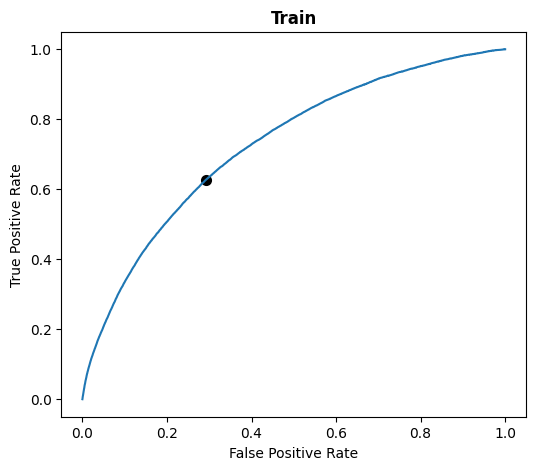

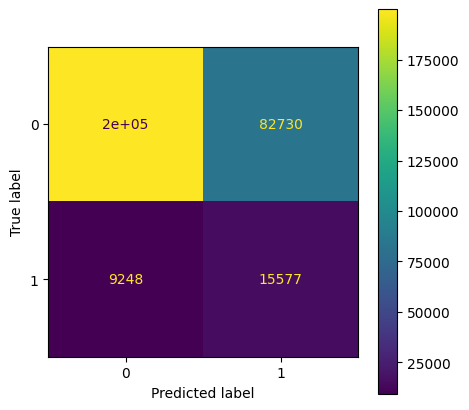

In [62]:
model = LogisticRegression(max_iter=500, class_weight='balanced', C=1e6)
pipe_LR = best_threshold(X_train_feature, pd.Series(y_train), 5, model, 0.45, 0.55)

In [63]:
filename = 'logistic_regression.pkl'
pickle.dump(pipe_LR, open(filename, 'wb'))

In [77]:
features_kept

,features
31,EXT_SOURCE_1
32,EXT_SOURCE_2
33,EXT_SOURCE_3
252,INCOME_CREDIT_PERC
294,BURO_CREDIT_TYPE_Car loan_MEAN
358,CLOSED_AMT_CREDIT_SUM_SUM
458,PREV_CODE_REJECT_REASON_SCOFR_MEAN
562,APPROVED_AMT_ANNUITY_MAX
732,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
736,CC_CNT_DRAWINGS_CURRENT_MAX


In [84]:
data_essai = pd.DataFrame(columns=features_kept['features'], data=[[0.564990, 0.291656, 0.432962 ,0.444409 ,0.0 ,5.850000e+04 ,0.0 ,4813.200 ,0.260137 ,3.0]])
data_essai

features,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_PERC,BURO_CREDIT_TYPE_Car loan_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,PREV_CODE_REJECT_REASON_SCOFR_MEAN,APPROVED_AMT_ANNUITY_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX
0,0.56499,0.291656,0.432962,0.444409,0.0,58500.0,0.0,4813.2,0.260137,3.0


In [85]:
pipe_LR.predict_proba(data_essai)

array([[0.39093465, 0.60906535]])

# Some customers for tests

In [64]:
some_customers = pd.read_csv('some_customers.csv')

In [65]:
some_customers

,Unnamed: 0,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,SK_ID_CURR
0,0,0.0,1.0,0.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,100001
1,1,0.0,0.0,0.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,100005
2,2,0.0,0.0,1.0,0.0,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,100013
3,3,0.0,1.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,100028
4,4,0.0,0.0,1.0,1.0,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,0.0,1.0,0.0,0.0,0.0,157500.0,375367.5,38592.0,337500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,136103
4996,4996,0.0,1.0,0.0,0.0,1.0,67500.0,450000.0,15498.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,136114
4997,4997,0.0,1.0,0.0,0.0,1.0,112500.0,707287.5,34155.0,562500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,136116
4998,4998,0.0,1.0,0.0,1.0,0.0,202500.0,848745.0,36090.0,675000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,136140


In [82]:
some_customers_10 = some_customers[features_kept['features']]
some_customers_10

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_PERC,BURO_CREDIT_TYPE_Car loan_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,PREV_CODE_REJECT_REASON_SCOFR_MEAN,APPROVED_AMT_ANNUITY_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX
0,0.752614,0.789654,0.159520,0.237342,0.0,5.693400e+05,0.0,3951.000,0.260137,3.0
1,0.564990,0.291656,0.432962,0.444409,0.0,5.850000e+04,0.0,4813.200,0.260137,3.0
2,0.506155,0.699787,0.610991,0.305308,0.5,2.072280e+06,0.0,23153.985,0.255556,7.0
3,0.525734,0.509677,0.612704,0.200000,0.0,6.561540e+05,0.0,11250.000,0.045455,12.0
4,0.202145,0.425687,0.533482,0.287770,0.0,4.350563e+05,0.0,11100.600,0.260137,3.0
...,...,...,...,...,...,...,...,...,...,...
4995,0.707119,0.719353,0.533482,0.419589,0.0,4.350563e+05,0.0,11294.280,0.260137,3.0
4996,0.488624,0.521228,0.226347,0.150000,0.0,6.023939e+05,0.0,6621.435,0.260137,3.0
4997,0.506155,0.646489,0.740799,0.159058,0.0,6.934500e+04,0.0,5201.730,0.260137,3.0
4998,0.470011,0.650049,0.590233,0.238588,0.0,8.969345e+05,0.0,14892.300,0.010417,1.0
